# Generating the disruption network
## And calculating the disruption index

One of the most important steps in studying the effect of disruption in songs is actually calculating it based on the similarity matrix we obtained before. That way we use the same list of songs that was used to generate the similarity matrix and use to calculate the disruption score for each song in our dataset. That means that after calculating we can find who were the songs most disruptive in our dataset based on its metadata.

## The code below generates a songs disruption network using:
1. list of songs (in the same order as the similarity matrix)
2. A similarity matrix (ordered by release) so we know that the next song i + 1 is a song released after i
3. A similarity threshold that will determine if there is an edge between nodes

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import collections

from tqdm import tqdm
from networkx.drawing.nx_pylab import draw_networkx

In [2]:
def generate_network(list_of_songs, similarity_matrix, similarity_threshold=0.80):
    """ Generate a disruption network based on: 
    If a song has a similarity with another over the threshold than an edge is made to connect both of them.

    Args:
        1. list of songs (in the same order as the similarity matrix)
        2. A similarity matrix (ordered by release) so we know that the next song i + 1 is a song released after i
        3. A similarity threshold that will determine if there is an edge between nodes
    Returns:
        A network as a networkx.DiGraph Object
    """
    slice_index = 0
    G = nx.DiGraph()

    for i in tqdm(range(len(list_of_songs))):
        edge_count = 0
        
        G.add_node(i)
        
        for j in range(i + 1, len(list_of_songs)):
            # If there is a high similarity, create an edge between the nodes
            if similarity_matrix[i][j] > similarity_threshold:
                G.add_edge(j, i)
                edge_count += 1
        
        # If this node does not have a similarity with any other node, then remove the node
        if edge_count < 1:
            G.remove_node(i)

    return G

def get_disruption_index_for_nodes(list_of_songs, graph):
    """ Compute the actual disruption indexes for the graph based on the nodes(songs) and its
    connections (if its influenced or if it influenced another song) """
    disruption_info = {}

    for i in tqdm(range(len(list_of_songs))):    
        if graph.has_node(i):
            songs_after = range(i + 1, len(list_of_songs))
            song_influences = [edge[1] for edge in graph.edges(i) if edge[1] != i]

            ni = 0
            nj = 0
            nk = 0
            
            for song_after in tqdm(songs_after):
                consolidating_influence = False
                if graph.has_edge(song_after , i):
                
                    for influence in song_influences:
                        if graph.has_edge(song_after, influence):
                            consolidating_influence = True
                            break
                
                    if consolidating_influence:
                        nj += 1
                    else:
                        ni += 1
                
                else:
                    for influence in song_influences:
                        if graph.has_edge(song_after, influence):
                            nk += 1
    
            disruption_info[list_of_songs.iloc[i]['id']] = [ni, nj, nk, float((ni-nj)) / float((ni+nj+nk))] if (ni + nj + nk) > 0 else [ni, nj, nk, 0]
    
    return disruption_info


## Loading our features, matrix and dataframe
The first step to build the network it is to load the files generated in prior steps

### `Information about the dataset:`
 - The filtered dataset refers removed the songs that their mp3 had no sound.

### `Information about the feature vectors:`
 -  Features can be both calculated using the MFCC or the concatenation of the features from the transfer learning convnet


### `Information about the similarity matrix:`

Similarity matrix can have more or less similarities between songs based on the gamma value
 - Higher means it is more strict
 - Lesser means that songs that are different will be deemed as similar

In [26]:
from pathlib import Path

DATASET_PATH = Path("./dataset")

def load_npy(file_path):
    print(f"Loading: {file_path} ...")
    return np.load(file_path)

def load_features_from_file(file_name, feature_type):
    if feature_type == "mfcc":
        return load_npy(DATASET_PATH / "input" / "feature_vectors" / "mfcc" / file_name)
    elif feature_type == "transfer_learning":
        return load_npy(DATASET_PATH / "input" / "feature_vectors" / "transfer_learning" / file_name)
    else:
        raise TypeError("This feature type is not supported")

def load_similarity_matrix(file_name, feature_type):
    if feature_type == "mfcc":
        return load_npy(DATASET_PATH / "input" / "similarity_matrices" / "mfcc" / file_name)
    elif feature_type == "transfer_learning":
        return load_npy(DATASET_PATH / "input" / "similarity_matrices" / "transfer_learning" / file_name)
    else:
        raise TypeError("This feature type is not supported")

def load_dataframe(dataframe_file):
    return pd.read_csv(DATASET_PATH / "input" / "csvs" / dataframe_file)

DF_PATH = "song_info_dataset_29986_entries_filtered.csv"
FEATS_PATH = "transfer_learning_feature_vector_29986_samples.npy"
SIMILARITY_MATRIX_PATH = "transfer_learning_29986_samples_0.1_gamma.npy"

dataframe = load_dataframe(DF_PATH)
features = load_features_from_file(FEATS_PATH, "transfer_learning")
similarity_matrix = load_similarity_matrix(SIMILARITY_MATRIX_PATH, "transfer_learning")

Loading: dataset/input/feature_vectors/transfer_learning/transfer_learning_feature_vector_29986_samples.npy ...
Loading: dataset/input/similarity_matrices/transfer_learning/transfer_learning_29986_samples_0.1_gamma.npy ...


Now we can call the functions defined above to generate the network and calculate the disruption index!

In [28]:
graph = generate_network(dataframe, similarity_matrix)

  0%|          | 4/29986 [00:00<1:27:35,  5.71it/s]


KeyboardInterrupt: 

In [ ]:
disruption_index = get_disruption_index_for_nodes(dataframe, graph)

Some of 29000+ songs used to build the network had no connection with any other, so they didn't even enter the network:

```
# If this node does not have a similarity with any other node, then remove the node
if edge_count < 1:
    G.remove_node(i)
```

That is why we have only 26091 with a disruption index

In [15]:
len(disruption_index)

26091

# Exporting the graph generated

Here we export the generated graph in a way we can analyse it on Gephi later

In [11]:
nx.write_gexf(graph, "transfer_learning_feats_gamma_0.1.gexf")

# Exporting the disruption index

In [29]:
import pickle

In [14]:
# Store data (serialize)
with open(DATASET_PATH / "output" / "disruption_index" / 'disruption_index.pickle', 'wb') as handle:
    pickle.dump(disruption_index, handle, protocol=pickle.HIGHEST_PROTOCOL)

### We should store as a dataframe too

In [32]:
with open(DATASET_PATH / "output" / "disruption_index" / 'transfer-learning-disruption-index-gamma-0-1.pickle', 'rb') as handle:
    loaded_disruption_index = pickle.load(handle)


### Generating the dataframe with the disruption index

In [40]:
disruption_index_df = pd.DataFrame(loaded_disruption_index).T
disruption_index_df.reset_index(inplace=True)
disruption_index_df.columns = ['id', 'ni', 'nj', 'nk', 'disruption']
disruption_index_df.head()


,id,ni,nj,nk,disruption
0,5pClePd8cdUOGQe2,37.0,0.0,0.0,1.0
1,3MEb9LZbB80nQ1a8,1.0,0.0,0.0,1.0
2,7TEMzPqSHWOHiojK,93.0,0.0,0.0,1.0
3,8rCzU7kVpoJ0Z37D,1.0,0.0,0.0,1.0
4,AHJbjIlp98gVY3Pj,2.0,0.0,0.0,1.0


Joining song info and song disruption datasets 

In [42]:
song_info_with_disruption = pd.merge(disruption_index_df, dataframe, on='id')
song_info_with_disruption.head()

,id,ni,nj,nk,disruption,artist,song,album_name,genres,popularity,release,duration_ms
0,5pClePd8cdUOGQe2,37.0,0.0,0.0,1.0,Los Espíritus,Lo Echaron del Bar,Los Espíritus,"latin,rock,psychedelic rock,latin,rock,psyched...",35.0,2013,268507
1,3MEb9LZbB80nQ1a8,1.0,0.0,0.0,1.0,Louis Armstrong,St. James Infirmary,The Complete Hot Five And Hot Seven Recordings...,"jazz,blues",29.0,1928,191867
2,7TEMzPqSHWOHiojK,93.0,0.0,0.0,1.0,Art Tatum,Tea for Two,Piano Starts Here,"jazz,jazz piano",46.0,1933,193867
3,8rCzU7kVpoJ0Z37D,1.0,0.0,0.0,1.0,Billie Holiday,A Fine Romance,Lady Day: The Complete Billie Holiday On Colum...,"jazz,jazz,blues",24.0,1933,171467
4,AHJbjIlp98gVY3Pj,2.0,0.0,0.0,1.0,Billie Holiday,Gloomy Sunday,Lady Day: The Complete Billie Holiday On Colum...,"jazz,blues,vocal jazz",49.0,1933,190800


In [ ]:
song_info_with_disruption.to_csv("song_info_with_disruption.csv", index=False)

In [17]:
# sort by disruption and then ni
sorted_x = sorted(disruption_index.items(), key=lambda kv: (kv[1][3], kv[1][0]), reverse=True)
sorted_dict = collections.OrderedDict(sorted_x)

In [25]:
list_of_songs = []
for song in sorted_dict.keys():
    #print("%s - %s" % (dataframe[dataframe['id'] ==  song][['song', 'artist', "release"]], sorted_dict[song]))
    list_of_songs.append(song)

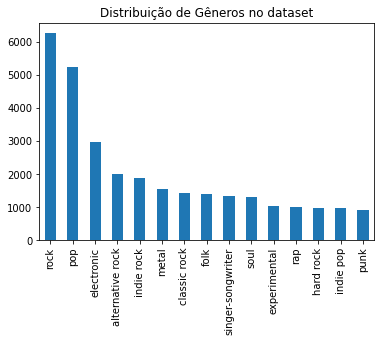

In [26]:
list_of_songs_df = dataframe[dataframe['id'].isin(list_of_songs)]
def plot_genre_distribution(df):
    # Needs a genre column
    genres = ",".join(df['genres']).split(",")
    genres_count = pd.Series(genres).value_counts()
    most_popular_genres = genres_count[:100]
    # Plot the 15 most popular
    ax = most_popular_genres[:15].plot.bar(title="Distribuição de Gêneros no dataset")

plot_genre_distribution(list_of_songs_df)

In [30]:
dataframe[dataframe['artist'] ==  'Frank Ocean']

,id,artist,song,album_name,genres,popularity,release,duration_ms
16708,3ZbcYuQtZUtcGtxe,Frank Ocean,Fertilizer,channel ORANGE,hip hop,51.0,2012,39640
16962,DEB4d9cP1YXgpOGJ,Frank Ocean,Crack Rock,channel ORANGE,soul,55.0,2012,224147
22224,78XDhPEcFuLGxB4t,Frank Ocean,Pretty Sweet,Blonde,"experimental,noise",56.0,2016,158478
22323,FEI4yctSyeux0vOb,Frank Ocean,Ivy,Blonde,soul,72.0,2016,249191
25184,5q2bv4u2NNpv0h3o,Frank Ocean,Chanel,Chanel,"hip hop,pop,art pop",73.0,2017,210285


In [32]:
# Using this to visualize other attributes on gephi
dataframe_to_export = dataframe.copy(deep=True)
dataframe_to_export['id'] = dataframe.index
dataframe_to_export.to_csv("df_with_id.csv", index=False)

In [38]:
count = 0
for song in sorted_dict.keys():
    print("%s - %s" % (dataframe[dataframe['id'] ==  song][['song', 'artist', "release"]], sorted_dict[song]))
    count += 1
    if count >= 10:
        break

                                  song                  artist  release
1140  Nineteen Hundred And Eighty Five  Paul McCartney & Wings     1973 - [657, 0, 0, 1.0]
             song      artist  release
128  If I Had You  Etta Jones     1960 - [424, 0, 0, 1.0]
             song artist  release
315  Orange Skies   Love     1966 - [290, 0, 0, 1.0]
              song         artist  release
1767  Fingerprints  Leonard Cohen     1977 - [277, 0, 0, 1.0]
                          song      artist  release
2098  Every Woman in the World  Air Supply     1980 - [266, 0, 0, 1.0]
                       song          artist  release
1036  Andromeda's Suffering  Alice Coltrane     1972 - [226, 0, 0, 1.0]
                        song       artist  release
222  House of the Rising Sun  The Animals     1964 - [217, 0, 0, 1.0]
       song     artist  release
1166  Rosie  Tom Waits     1973 - [217, 0, 0, 1.0]
                                 song     artist  release
255  Never Met a Girl Like You Before 